### Проверка гипотез
- \[ \] Гипотеза 1. Если ли различия в доле опасного газа от смены?
- \[ \] Гипотеза 2. Какая из смен лучше управляет температурой верха на этапе 3? Считать, что высокая температура хуже.
- \[ \] Гипотеза 3. Конверсия мономера на 1 этапе влияет на количество подаваемой суммарной воды.
- \[ \] Гипотеза 4. Количество выходного количества продукта связано с долей опасного газа
- \[ \] Гипотезы 5-7. Дополнительно выдвинуть и проверить не менее 3 гипотез по влиянию разных факторов на любой из выходных параметров этапа 4.

In [1]:
import pandas as pd
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
PATH = '../analysing_environmental_issues.csv'
df = pd.read_csv(PATH, sep=",")

%run ../remove_outliers/remove_outliers_run.ipynb

df = hybrid_outlier_handling(df, df.columns[1:-1])

%run ../nans_and_columns/initial_data_handlers_run.ipynb

convert_to_DateTime(df)

df = nan_to_interpolate(df)
df = convert_to_category(df)

In [6]:
def draw_separation_line():
    print("\n" * 2 + "#" * 120 + "\n" * 2)

### Проверка гипотезы 1

По сути есть ли зависимость `stage_4_output_danger_gas` и `work_shift`.

Для начала разделяем `stage_4_output_danger_gas` на две смены `work_shift=1` `worsk_shift=2`. Проверяем на нормальность с помощью Shapiro и на основе этого применяем или U-критерий Манна — Уитни, или t-критерий Стьюдента.

In [7]:
def is_normal_distribution(data, alpha=0.05):
    """Проверка нормальности распределения с помощью теста Шапиро-Уилка."""
    stat, p_value = shapiro(data)
    print(f"Тест Шапиро-Уилка: W-статистика = {stat:.4f}, p-значение = {p_value:.2e}")
    return p_value > alpha  # True, если данные нормально распределены

def print_summary_statistics(label, data):
    # Вывод основных статистических характеристик
    print(f"{label}:")
    print(f"  Среднее значение = {data.mean():.4f}")
    print(f"  Медиана = {data.median():.4f}")
    print(f"  Стандартное отклонение = {data.std():.4f}")
    print(f"  Размер выборки = {len(data)}\n")

def test_hypothesis_1(df):
    # Разделение данных по сменам
    shift_1 = df[df['work_shift'] == 1]['stage_4_output_danger_gas']
    shift_2 = df[df['work_shift'] == 2]['stage_4_output_danger_gas']
    
    # Основные статистические характеристики
    print("Основные статистические характеристики:")
    print_summary_statistics("Смена 1", shift_1)
    print_summary_statistics("Смена 2", shift_2)
    
    # Проверка нормальности распределения
    print("Проверка нормальности распределения:")
    shift_1_normal = is_normal_distribution(shift_1)
    shift_2_normal = is_normal_distribution(shift_2)
    
    # Проверка гипотез
    print("\nПроверка гипотез:")
    if shift_1_normal and shift_2_normal:
        # Если оба распределения нормальные, используем Student's t-test
        t_stat, p_value = ttest_ind(shift_1, shift_2, equal_var=False)  # Welch's t-test
        print("Student's t-test:")
        print(f"  T-статистика: {t_stat:.4f}, p-значение: {p_value:.4f}")
        if p_value < 0.05:
            print("  Отклоняем нулевую гипотезу: Доля газа зависит от смены.")
        else:
            print("  Не удалось отклонить нулевую гипотезу: Доля газа НЕ зависит от смены.")
    else:
        # Если хотя бы одно распределение не является нормальным, используем Mann-Whitney U test
        u_stat, p_value = mannwhitneyu(shift_1, shift_2, alternative='two-sided')
        print("Mann-Whitney U Test:")
        print(f"  U-статистика: {u_stat:.4f}, p-значение: {p_value:.4f}")
        if p_value < 0.05:
            print("  Отклоняем нулевую гипотезу: Доля газа зависит от смены.")
        else:
            print("  Не удалось отклонить нулевую гипотезу: Доля газа НЕ зависит от смены.")


print("Проверка гипотезы 1:")
test_hypothesis_1(df)

Проверка гипотезы 1:
Основные статистические характеристики:
Смена 1:
  Среднее значение = 0.1385
  Медиана = 0.1400
  Стандартное отклонение = 0.0332
  Размер выборки = 2285

Смена 2:
  Среднее значение = 0.1380
  Медиана = 0.1367
  Стандартное отклонение = 0.0342
  Размер выборки = 2115

Проверка нормальности распределения:
Тест Шапиро-Уилка: W-статистика = 0.9953, p-значение = 1.30e-06
Тест Шапиро-Уилка: W-статистика = 0.9946, p-значение = 6.16e-07

Проверка гипотез:
Mann-Whitney U Test:
  U-статистика: 2452827.0000, p-значение: 0.3867
  Не удалось отклонить нулевую гипотезу: Доля газа НЕ зависит от смены.


> На основе **p-value** можно понять, что нам не удалось опровергнуть нулевую гипотезу: нет различий в доле опасного газа от смены.

### Проверка гипотезы 2

1. **Нулевая гипотеза**: Распределение температур для обеих смен одинаково.
2. **Альтернативная гипотеза**: Распределения (или средние) различны, и у более эффективной смены значения будут значительно ниже.

In [8]:
def print_summary_statistics(label, data):
    """Вывод основных статистических характеристик."""
    print(f"{label}:")
    print(f"  Среднее значение = {data.mean():.4f}")
    print(f"  Медиана = {data.median():.4f}")
    print(f"  Стандартное отклонение = {data.std():.4f}")
    print(f"  Размер выборки = {len(data)}\n")


def test_hypothesis_2(df):
    # Извлечение данных по сменам
    shift_1 = df[df['work_shift'] == 1]['stage_3_output_temp_top']
    shift_2 = df[df['work_shift'] == 2]['stage_3_output_temp_top']
    
    # Основные статистические характеристики
    print("Основные статистические характеристики температуры на этапе 3:")
    print_summary_statistics("Смена 1", shift_1)
    print_summary_statistics("Смена 2", shift_2)
    
    # Проверка нормальности распределения
    print("Проверка нормальности распределения:")
    print("Смена 1:")
    shift_1_normal = is_normal_distribution(shift_1)
    print("Смена 2:")
    shift_2_normal = is_normal_distribution(shift_2)
    
    # Всегда сравниваем средние значения
    print("\nПроверка гипотезы (сравнение средних):")
    if shift_1_normal and shift_2_normal:
        # Если оба распределения нормальные, используем Welch's t-test
        t_stat, p_value = ttest_ind(shift_1, shift_2, equal_var=False)
        print("Student's t-test (Welch's):")
        print(f"  T-статистика: {t_stat:.4f}, p-значение: {p_value:.4f}")
    else:
        # Если хотя бы одно распределение не является нормальным, используем Mann-Whitney U test
        print("Распределения ненормальные, используем Mann-Whitney U Test.")
        u_stat, p_value = mannwhitneyu(shift_1, shift_2, alternative='two-sided')
        print(f"Mann-Whitney U Test:")
        print(f"  U-статистика: {u_stat:.4f}, p-значение: {p_value:.4f}")
    
    # Определение смены с более низким средним значением температуры
    better_shift = "Смена 1" if shift_1.mean() < shift_2.mean() else "Смена 2"
    print(f"Смена с более низкой средней температурой: {better_shift}")
    print(f"(Средняя температура Смена 1 = {shift_1.mean():.4f}, Смена 2 = {shift_2.mean():.4f})")
    
    # Заключение о значимости
    if p_value < 0.05:
        print(f"Есть статистически значимая разница: {better_shift} лучше управляет температурой.")
    else:
        print(f"Нет статистически значимой разницы между сменами, но у {better_shift} ниже средняя температура.")


draw_separation_line()
print("Проверка гипотезы 2:")
test_hypothesis_2(df)



########################################################################################################################


Проверка гипотезы 2:
Основные статистические характеристики температуры на этапе 3:
Смена 1:
  Среднее значение = 42.7207
  Медиана = 44.1100
  Стандартное отклонение = 4.5573
  Размер выборки = 2285

Смена 2:
  Среднее значение = 42.8537
  Медиана = 44.1400
  Стандартное отклонение = 4.3790
  Размер выборки = 2115

Проверка нормальности распределения:
Смена 1:
Тест Шапиро-Уилка: W-статистика = 0.8766, p-значение = 3.04e-39
Смена 2:
Тест Шапиро-Уилка: W-статистика = 0.8575, p-значение = 4.11e-40

Проверка гипотезы (сравнение средних):
Распределения ненормальные, используем Mann-Whitney U Test.
Mann-Whitney U Test:
  U-статистика: 2406654.5000, p-значение: 0.8172
Смена с более низкой средней температурой: Смена 1
(Средняя температура Смена 1 = 42.7207, Смена 2 = 42.8537)
Нет статистически значимой разницы между сменами, но у Смена 1 ниже средняя температура.


> На основе **p-value** можно понять, что нам не удалось опровергнуть нулевую гипотезу: нет различий в доле опасного газа от смены.

### Проверка гипотезы 3



########################################################################################################################


Проверка гипотезы 3:
Проверка нормальности распределения:
Тест Шапиро-Уилка: W-статистика = 0.9708, p-значение = 4.69e-29
Тест Шапиро-Уилка: W-статистика = 0.9881, p-значение = 7.86e-19

Анализ корреляции:
Хотя бы одна переменная ненормально распределена. Применяем корреляцию Спирмена.

Результаты корреляционного анализа:
Коэффициент корреляции: 0.0076
p-значение: 6.1392e-01
Не удается отклонить нулевую гипотезу: Значимой связи между конверсией мономера и количеством подаваемой воды нет.


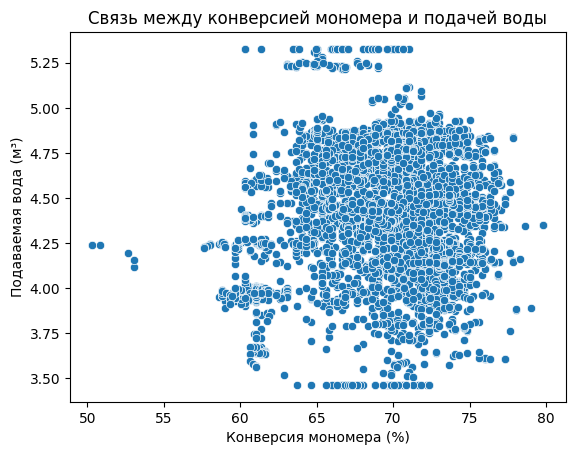

In [9]:
def test_hypothesis_3(df):
    """
    Проверяет, связана ли конверсия мономера на 1 этапе с количеством подаваемой воды на 2 этапе.
    """
    # Извлечение данных
    conversion = df['stage_1_output_konv_avd']  # Конверсия мономера на 1 этапе
    water_input = df['stage_2_input_water_sum']  # Количество подаваемой воды на 2 этапе
    
    # Проверка нормальности распределения
    print("Проверка нормальности распределения:")
    conversion_normal = is_normal_distribution(conversion)
    water_input_normal = is_normal_distribution(water_input)
    
    # Выбор метода корреляции
    print("\nАнализ корреляции:")
    if conversion_normal and water_input_normal:
        print("Обе переменные нормально распределены. Применяем корреляцию Пирсона.")
        corr, p_value = pearsonr(conversion, water_input)
    else:
        print("Хотя бы одна переменная ненормально распределена. Применяем корреляцию Спирмена.")
        corr, p_value = spearmanr(conversion, water_input)
    
    # Результаты корреляции
    print("\nРезультаты корреляционного анализа:")
    print(f"Коэффициент корреляции: {corr:.4f}")
    print(f"p-значение: {p_value:.4e}")
    
    # Интерпретация результатов
    if p_value < 0.05:
        print("Отклоняем нулевую гипотезу: Есть значимая связь между конверсией мономера и количеством подаваемой воды.")
    else:
        print("Не удается отклонить нулевую гипотезу: Значимой связи между конверсией мономера и количеством подаваемой воды нет.")
    
    # Построение графика
    sns.scatterplot(x=conversion, y=water_input)
    plt.title("Связь между конверсией мономера и подачей воды")
    plt.xlabel("Конверсия мономера (%)")
    plt.ylabel("Подаваемая вода (м³)")
    plt.show()


draw_separation_line()
print("Проверка гипотезы 3:")
test_hypothesis_3(df)

### Проверка гипотезы 4

Количество выходного количества продукта (`stage_4_output_product`) связано с долей опасного газа (`stage_4_output_danger_gas`)



########################################################################################################################


Проверка гипотезы 4:
Основные статистические характеристики:
Средняя доля опасного газа: 0.1383
Средний выход продукта: 46.2632

Проверка нормальности распределения:
stage_4_output_danger_gas
Тест Шапиро-Уилка: W-статистика = 0.9958, p-значение = 7.97e-10
stage_4_output_product
Тест Шапиро-Уилка: W-статистика = 0.9628, p-значение = 3.36e-32

Анализ корреляции:
Хотя бы одна переменная ненормально распределена. Применяем корреляцию Спирмена.

Результаты корреляционного анализа:
Коэффициент ранговой корреляции Спирмена: -0.0437, p-значение: 3.7699e-03

Результат: Есть статистически значимая связь между долей опасного газа и количеством выходного продукта.


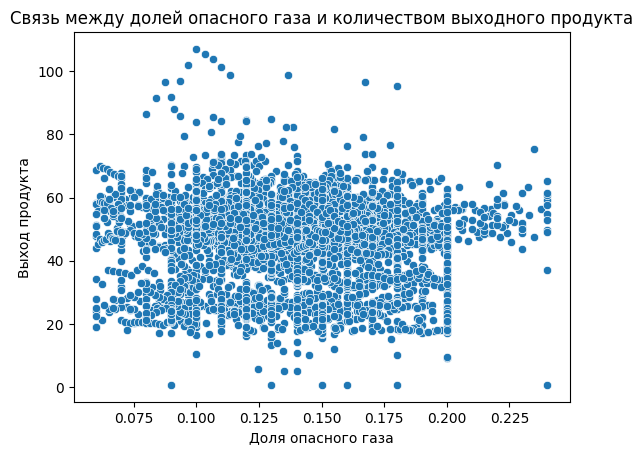

In [10]:
def test_hypothesis_4(df):
    """
    Проверяет, связана ли доля опасного газа с количеством выходного продукта.
    """
    # Извлечение данных
    danger_gas = df['stage_4_output_danger_gas']  # Доля опасного газа
    output_product = df['stage_4_output_product']  # Количество выходного продукта
    
    # Основные статистические характеристики
    print("Основные статистические характеристики:")
    print(f"Средняя доля опасного газа: {danger_gas.mean():.4f}")
    print(f"Средний выход продукта: {output_product.mean():.4f}")
    
    # Проверка нормальности распределения
    print("\nПроверка нормальности распределения:")
    print("stage_4_output_danger_gas")
    danger_gas_normal = is_normal_distribution(danger_gas)
    print("stage_4_output_product")
    output_product_normal = is_normal_distribution(output_product)
    
    # Выбор метода корреляции
    print("\nАнализ корреляции:")
    if danger_gas_normal and output_product_normal:
        print("Обе переменные нормально распределены. Применяем корреляцию Пирсона.")
        corr_stat, p_value = pearsonr(danger_gas, output_product)
        method = "Коэффициент корреляции Пирсона"
    else:
        print("Хотя бы одна переменная ненормально распределена. Применяем корреляцию Спирмена.")
        corr_stat, p_value = spearmanr(danger_gas, output_product)
        method = "Коэффициент ранговой корреляции Спирмена"
    
    # Результаты корреляции
    print("\nРезультаты корреляционного анализа:")
    print(f"{method}: {corr_stat:.4f}, p-значение: {p_value:.4e}")
    
    # Интерпретация результатов
    if p_value < 0.05:
        print(f"\nРезультат: Есть статистически значимая связь между долей опасного газа и количеством выходного продукта.")
    else:
        print(f"\nРезультат: Значимой связи между долей опасного газа и количеством выходного продукта не обнаружено.")
    
    # Построение графика
    sns.scatterplot(x=danger_gas, y=output_product)
    plt.title("Связь между долей опасного газа и количеством выходного продукта")
    plt.xlabel("Доля опасного газа")
    plt.ylabel("Выход продукта")
    plt.show()


draw_separation_line()
print("Проверка гипотезы 4:")
test_hypothesis_4(df)

### Проверка гипотезы 5

Входной полимер на этапе 4 влияет на количество выходного продукта на этапе 4.

`stage_4_input_polymer` **->** `stage_4_output_product`



########################################################################################################################


Проверка гипотезы 5:
Основные статистические характеристики:
Среднее количество полимера: 20.1917
Среднее количество выходного продукта: 46.2632

Проверка нормальности распределения:
Количество полимера (stage_4_input_polymer):
Тест Шапиро-Уилка: W-статистика = 0.9796, p-значение = 1.20e-24
Количество выходного продукта (stage_4_output_product):
Тест Шапиро-Уилка: W-статистика = 0.9628, p-значение = 3.36e-32

Анализ корреляции:
Хотя бы одна переменная ненормально распределена. Применяем корреляцию Спирмена.
Коэффициент ранговой корреляции Спирмена: 0.1376, p-значение: 4.7405e-20

Результат: Есть статистически значимая связь между количеством полимера на входе и количеством выходного продукта.


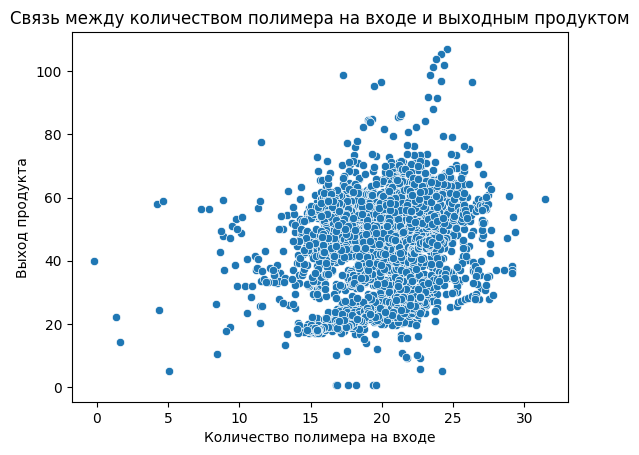

In [11]:
def test_hypothesis_5(df):
    # Извлечение данных
    input_polymer = df['stage_4_input_polymer']  # Количество полимера на входе
    output_product = df['stage_4_output_product']  # Количество выходного продукта
    
    # Основные статистические характеристики
    print("Основные статистические характеристики:")
    print(f"Среднее количество полимера: {input_polymer.mean():.4f}")
    print(f"Среднее количество выходного продукта: {output_product.mean():.4f}")
    
    # Проверка нормальности распределения
    print("\nПроверка нормальности распределения:")
    print("Количество полимера (stage_4_input_polymer):")
    input_polymer_normal = is_normal_distribution(input_polymer)
    print("Количество выходного продукта (stage_4_output_product):")
    output_product_normal = is_normal_distribution(output_product)
    
    # Выбор типа корреляционного анализа
    print("\nАнализ корреляции:")
    if input_polymer_normal and output_product_normal:
        print("Обе переменные нормально распределены. Применяем корреляцию Пирсона.")
        corr_stat, p_value = pearsonr(input_polymer, output_product)
        print(f"Коэффициент корреляции Пирсона: {corr_stat:.4f}, p-значение: {p_value:.4e}")
    else:
        print("Хотя бы одна переменная ненормально распределена. Применяем корреляцию Спирмена.")
        corr_stat, p_value = spearmanr(input_polymer, output_product)
        print(f"Коэффициент ранговой корреляции Спирмена: {corr_stat:.4f}, p-значение: {p_value:.4e}")
    
    # Интерпретация результатов
    if p_value < 0.05:
        print(f"\nРезультат: Есть статистически значимая связь между количеством полимера на входе и количеством выходного продукта.")
    else:
        print(f"\nРезультат: Значимой связи между количеством полимера на входе и количеством выходного продукта не обнаружено.")
    
    # Визуализация
    sns.scatterplot(x=input_polymer, y=output_product)
    plt.title("Связь между количеством полимера на входе и выходным продуктом")
    plt.xlabel("Количество полимера на входе")
    plt.ylabel("Выход продукта")
    plt.show()


draw_separation_line()
print("Проверка гипотезы 5:")
test_hypothesis_5(df)

### Проверка гипотезы 6

Вакуум низа на этапе 2 влияет на количество выходного продукта на этапе 4.

`stage_2_output_top_vacuum` **->** `stage_4_output_product`



########################################################################################################################


Проверка гипотезы 6:
Основные статистические характеристики:
Средний вакуум на 2 этапе: 59.1224
Средний продукт на 4 этапе: 46.2632

Проверка нормальности распределения:
stage_2_output_top_vacuum:
Тест Шапиро-Уилка: W-статистика = 0.9471, p-значение = 3.94e-37
stage_4_output_product:
Тест Шапиро-Уилка: W-статистика = 0.9628, p-значение = 3.36e-32

Анализ корреляции:
Хотя бы одна переменная ненормально распределена. Применяем корреляцию Спирмена.
Коэффициент ранговой корреляции Спирмена: -0.0119, p-значение: 4.2953e-01

Результат: Значимой связи между вакуумом на 2 этапе и продуктом на 4 этапе не обнаружено.


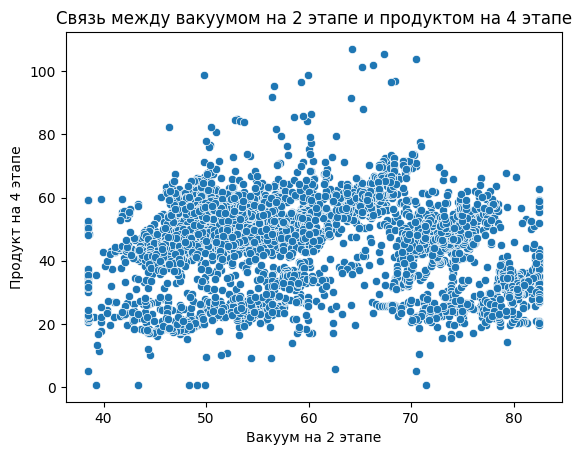

In [12]:
def test_hypothesis_6(df):
    # Извлечение данных
    top_vacuum = df['stage_2_output_top_vacuum']  # Вакуум на 2 этапе
    product_output = df['stage_4_output_product']  # Продукт на 4 этапе
    
    # Основные статистические характеристики
    print("Основные статистические характеристики:")
    print(f"Средний вакуум на 2 этапе: {top_vacuum.mean():.4f}")
    print(f"Средний продукт на 4 этапе: {product_output.mean():.4f}")
    
    # Проверка нормальности распределения
    print("\nПроверка нормальности распределения:")
    print("stage_2_output_top_vacuum:")
    top_vacuum_normal = is_normal_distribution(top_vacuum)
    print("stage_4_output_product:")
    product_output_normal = is_normal_distribution(product_output)
    
    # Выбор типа корреляционного анализа
    print("\nАнализ корреляции:")
    if top_vacuum_normal and product_output_normal:
        print("Обе переменные нормально распределены. Применяем корреляцию Пирсона.")
        corr_stat, p_value = pearsonr(top_vacuum, product_output)
        print(f"Коэффициент корреляции Пирсона: {corr_stat:.4f}, p-значение: {p_value:.4e}")
    else:
        print("Хотя бы одна переменная ненормально распределена. Применяем корреляцию Спирмена.")
        corr_stat, p_value = spearmanr(top_vacuum, product_output)
        print(f"Коэффициент ранговой корреляции Спирмена: {corr_stat:.4f}, p-значение: {p_value:.4e}")
    
    # Интерпретация результатов
    if p_value < 0.05:
        print(f"\nРезультат: Есть статистически значимая связь между вакуумом на 2 этапе и продуктом на 4 этапе.")
    else:
        print(f"\nРезультат: Значимой связи между вакуумом на 2 этапе и продуктом на 4 этапе не обнаружено.")
    
    # Визуализация
    sns.scatterplot(x=top_vacuum, y=product_output)
    plt.title("Связь между вакуумом на 2 этапе и продуктом на 4 этапе")
    plt.xlabel("Вакуум на 2 этапе")
    plt.ylabel("Продукт на 4 этапе")
    plt.show()


draw_separation_line()
print("Проверка гипотезы 6:")
test_hypothesis_6(df)

### Проверка гипотезы 7

Среднее содержание сухого остатка на этапе 4 зависит от температуры на верху на этапе 3.

`stage_3_output_temp_top` -> `stage_4_output_dry_residue_avg`



########################################################################################################################


Проверка гипотезы 7:
Основные статистические характеристики:
Средняя температура на 3 этапе: 42.7846
Средний остаток на 4 этапе: 22.4307

Проверка нормальности распределения:
stage_3_output_temp_top:
Тест Шапиро-Уилка: W-статистика = 0.8682, p-значение = 1.43e-51
stage_4_output_dry_residue_avg:
Тест Шапиро-Уилка: W-статистика = 0.9805, p-значение = 3.59e-24

Анализ корреляции:
Хотя бы одна переменная ненормально распределена. Применяем корреляцию Спирмена.
Коэффициент ранговой корреляции Спирмена: 0.2013, p-значение: 1.9114e-41

Результат: Есть статистически значимая связь между температурой верха на 3 этапе и средним остатком на 4 этапе.


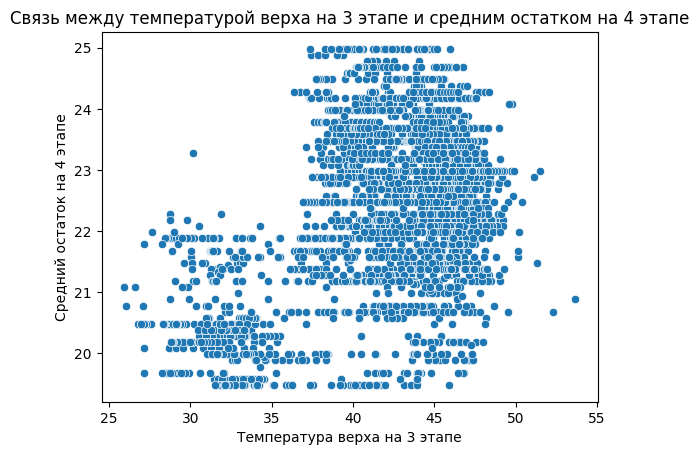

In [13]:
def test_hypothesis_7(df):
    # Извлечение данных
    temp_top = df['stage_3_output_temp_top']  # Температура верха на 3 этапе
    dry_residue_avg = df['stage_4_output_dry_residue_avg']  # Средний остаток на 4 этапе
    
    # Основные статистические характеристики
    print("Основные статистические характеристики:")
    print(f"Средняя температура на 3 этапе: {temp_top.mean():.4f}")
    print(f"Средний остаток на 4 этапе: {dry_residue_avg.mean():.4f}")
    
    # Проверка нормальности распределения
    print("\nПроверка нормальности распределения:")
    print("stage_3_output_temp_top:")
    temp_top_normal = is_normal_distribution(temp_top)
    print("stage_4_output_dry_residue_avg:")
    dry_residue_avg_normal = is_normal_distribution(dry_residue_avg)
    
    # Выбор типа корреляционного анализа
    print("\nАнализ корреляции:")
    if temp_top_normal and dry_residue_avg_normal:
        print("Обе переменные нормально распределены. Применяем корреляцию Пирсона.")
        corr_stat, p_value = pearsonr(temp_top, dry_residue_avg)
        print(f"Коэффициент корреляции Пирсона: {corr_stat:.4f}, p-значение: {p_value:.4e}")
    else:
        print("Хотя бы одна переменная ненормально распределена. Применяем корреляцию Спирмена.")
        corr_stat, p_value = spearmanr(temp_top, dry_residue_avg)
        print(f"Коэффициент ранговой корреляции Спирмена: {corr_stat:.4f}, p-значение: {p_value:.4e}")
    
    # Интерпретация результатов
    if p_value < 0.05:
        print(f"\nРезультат: Есть статистически значимая связь между температурой верха на 3 этапе и средним остатком на 4 этапе.")
    else:
        print(f"\nРезультат: Значимой связи между температурой верха на 3 этапе и средним остатком на 4 этапе не обнаружено.")
    
    # Визуализация
    sns.scatterplot(x=temp_top, y=dry_residue_avg)
    plt.title("Связь между температурой верха на 3 этапе и средним остатком на 4 этапе")
    plt.xlabel("Температура верха на 3 этапе")
    plt.ylabel("Средний остаток на 4 этапе")
    plt.show()


draw_separation_line()
print("Проверка гипотезы 7:")
test_hypothesis_7(df)

### График корреляций

In [14]:
def visualize_correlation_matrix(correlation_matrix, title="The best graphic"): # красивый график ВСЕХ корреляций(колличественных)
    """
    Рисует график корреляций всех колличественных признаков(и не только, если надо).

    Аругменты:
        correlation_matrix:  Фрейм данных Pandas, представляющий корреляционную матрицу.
        threshold: Название графика.
    """
    for col in correlation_matrix.columns: # цикл повторяется по каждому столбцу корреляционной матрицы.
        correlation_matrix[col] = pd.to_numeric(correlation_matrix[col], errors='coerce') # спасает от вылета программы.

    #correlation_matrix_np = correlation_matrix.values # преобразует фрейм данных Pandas в массив NumPy

    plt.figure(figsize=(10, 8))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest') # создание тепловой карты корреляций

    plt.colorbar(label='Correlation')

    plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
    plt.yticks(range(len(correlation_matrix.index)), correlation_matrix.index)

    plt.title(title)
    plt.show()

In [17]:
columns = df.columns[:-1] # создаём переменную с названиями признаков,
                           # кроме "work_shift", т.к. это бинарный фактор

correlation_matrix_spearman = pd.DataFrame(index=columns, columns=columns)

for chunk in pd.read_csv("../analysing_environmental_issues.csv", sep=',', chunksize=750): # считываем все данные
                                                                                        # порциями по 750 строк
  for col in chunk.columns[1:-1]: # замена пропусков медианой в каждом столбце
      median_val = chunk[col].median()
      chunk[col] = chunk[col].fillna(median_val)

  for col1 in columns: # вычисление коэффициентов корелляции для всех пар столбцов
        for col2 in columns:
            corr_spearman, p_value_spearman = spearmanr(chunk[col1], chunk[col2])

            correlation_matrix_spearman.loc[col1, col2] = corr_spearman
            #устанавливаем в качестве значения коэффициенты корреляции в нужную ячейку

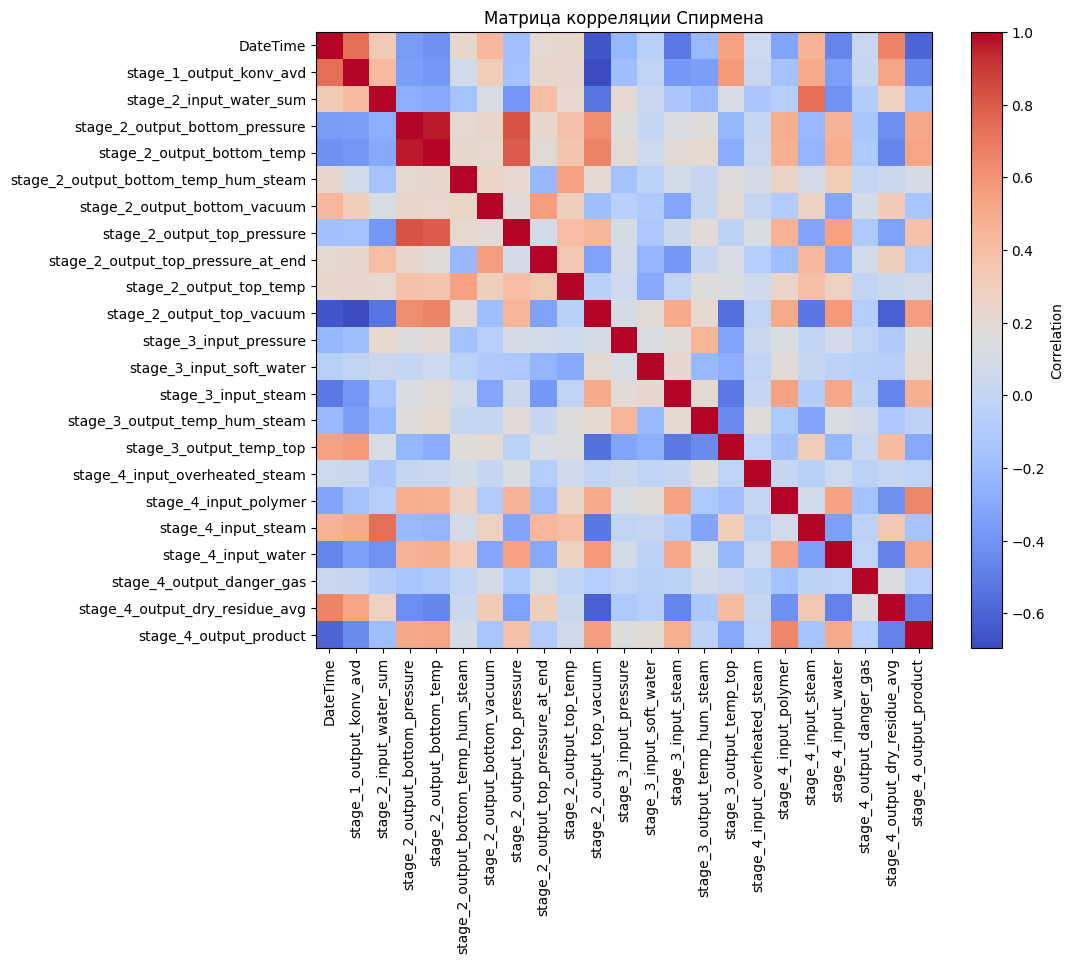

In [18]:
visualize_correlation_matrix(correlation_matrix_spearman, 'Матрица корреляции Спирмена')